# Effect of replacing Child Tax Credit with Child Dividend

This identifies beneficiaries of the Child Tax Credit by modeling its repeal on a static basis, both against current and pre-TCJA law. Change to after-tax income by decile, inequality, and poverty rates are calculated.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.20.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 500
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Specify number of decimals in tables.
pd.set_option('precision', 2)

### Utilities

From https://stackoverflow.com/a/49571213/1840471.

In [6]:
def gini(x, w=None, zero_negatives=True):
    # Requires float numpy arrays (not pandas Series or lists) to work.
    x = np.array(x).astype('float')
    if zero_negatives:
        x[x < 0] = 0
    if w is not None:
        w = np.array(w).astype('float')
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumxw = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumxw) / cumxw[-1]) / n

2018 HHS Poverty Guidelines (Federal Poverty Level) for 48 Contiguous States and District of Columbia (Alaska and Hawaii have higher guidelines, but the data does not have state code): https://aspe.hhs.gov/poverty-guidelines

In [7]:
def fpl(XTOT):
    return 7820 + 4320 * XTOT

In [8]:
def weighted_sum(df, col):
    return (df[col] * df.s006).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

### Create reforms

CTC repeal involves eliminating the normal CTC as well as the new dependent credit for children.

A reform to return to 2017 CTC law is used to show how the distribution of CTC benefits changed with TCJA.

In [9]:
noctc_reform = {
    2018: {
        "_CTC_c": [0],
        # Include old phase-out because it affects the non-child dep credit.
        "_CTC_ps": [[75000.0, 110000.0, 55000.0, 75000.0, 75000.0]],
        "_DependentCredit_Child_c": [0.0],
        "_DependentCredit_before_CTC": [False]
    }
}

y2017_reform = {
    2018: {
        # Current: 1400.0
        "_CTC_c": [1000.0],
        # Current: [200000.0, 400000.0, 200000.0, 200000.0, 400000.0]
        "_CTC_ps": [[75000.0, 110000.0, 55000.0, 75000.0, 75000.0]],
        # Current: 2500.0
        "_ACTC_Income_thd": [3000.0],
        # Current: 600.0
        "_DependentCredit_Child_c": [0.0],
        # Current: True
        "_DependentCredit_before_CTC": [False]
    }
}

## Generate data

In [10]:
recs = tc.Records.cps_constructor()

In [11]:
def static_baseline_calc(year):
    calc = tc.Calculator(records=recs, policy=tc.Policy())
    calc.advance_to_year(year)
    calc.calc_all()
    return calc

In [12]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df.s006.cumsum() / df.s006.sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, 
                              df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_2percentile'] = np.ceil(df[col_pctile] / 2).astype(int)
    df[col + '_ventile'] = np.ceil(df[col_pctile] / 5).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [58]:
def static_calc(ctc_treatment='keep',
                year=2018,
                cols=['RECID', 's006', 'aftertax_income', 'expanded_income',
                      'n24', 'XTOT', 'c07220', 'c11070', 'dep_credit'],
                child_tax_units_only=True):
    """Creates static Calculator.

    Args:
        ctc_treatment: How the Child Tax Credit is treated. Options include:
            * 'keep': No change. Default.
            * 'repeal': End entirely.
            * 'y2017': Use 2017 law.
        year: Year to advance calculations to.
        cols: Columns to extract per Calculator record. 
            Defaults to ['s006', 'expanded_income', 'aftertax_income', 'nu18',
            'n24', 'XTOT'].
        child_tax_units_only: Limit tax units to those with n24 > 0. 
            Quantiles are calculated after this filtering. Defaults to true.
        
    Returns:
        DataFrame with `cols` and percentile, decile, and quintile of 
        after-tax income.
    """
    pol = tc.Policy()
    # Enact reform based on ctc_treatment.
    # Repeal CTC unless it's kept.
    if ctc_treatment == 'y2017':
        pol.implement_reform(y2017_reform)
    elif ctc_treatment == 'repeal':
        pol.implement_reform(noctc_reform)
    # Calculate. This is needed to calculate the revenue-neutral UBI.
    calc = tc.Calculator(records=recs, policy=pol, verbose=False)
    calc.advance_to_year(year)
    calc.calc_all()
    # Create DataFrame and add identifiers.
    df = calc.dataframe(cols)
    if child_tax_units_only:
        df = df[df.n24 > 0]
    # Add percentiles.
    df = add_weighted_quantiles(df, 'expanded_income')
    df = add_weighted_quantiles(df, 'aftertax_income')
    # Add identifier.
    df['ctc_treatment'] = ctc_treatment
    # What's the column for the ID?
#     df['id'] = df.index
    # Add weighted sums.
    df['s006_m'] = df.s006 / 1e6
    df['s006_b'] = df.s006 / 1e9
    df['expanded_income_b'] = df.expanded_income * df.s006_b
    df['aftertax_income_b'] = df.aftertax_income * df.s006_b
    df['n24_m'] = df.n24 * df.s006_m
    df['XTOT_m'] = df.XTOT * df.s006_m
    return df

In [59]:
scenarios = pd.concat([
    static_calc(ctc_treatment='keep'),
    static_calc(ctc_treatment='y2017'),
    static_calc(ctc_treatment='repeal')])

## Program cost and child allowance calculation

In [60]:
afti_summary = (
    scenarios.groupby('ctc_treatment')['aftertax_income_b', 'n24_m'].sum())
n24_m_total = afti_summary.iloc[0].n24_m
ctc_cost_b = (afti_summary.loc['keep'].aftertax_income_b -
              afti_summary.loc['repeal'].aftertax_income_b)
rev_neutral_ubi_per_n24 = 1000 * ctc_cost_b / n24_m_total
MAX_CTC = 2000
top_ubi_cost_b = n24_m_total * MAX_CTC / 1000 - ctc_cost_b
top_ubi_cost_b_pct = top_ubi_cost_b / ctc_cost_b

In [61]:
print('The CTC has an estimated total 2018 cost of ' + 
      '${:.1f}'.format(ctc_cost_b) + 'B.\n' +
      'This could fund a ${:,.0f}'.format(rev_neutral_ubi_per_n24) +
      ' child benefit for all {:,.1f}'.format(n24_m_total) +
      'M CTC-eligible children.\n' +
      'Topping up to $2,000 per CTC-eligible child would cost ' +
      '${:.1f}'.format(top_ubi_cost_b) + 
      'B, a {:.1f}'.format(top_ubi_cost_b_pct * 100) + '% increase.')

The CTC has an estimated total 2018 cost of $118.1B.
This could fund a $1,483 child benefit for all 79.6M CTC-eligible children.
Topping up to $2,000 per CTC-eligible child would cost $41.1B, a 34.8% increase.


Two comparison points:

1. PUF/TaxBrain estimates \$112.4B
2. [TPC's 2017 estimate](http://www.taxpolicycenter.org/publications/refundable-credits-earned-income-tax-credit-and-child-tax-credit/full) of \$52B plus [JCT's estimate](https://www.jct.gov/publications.html?func=startdown&id=5053) that TCJA's non-SSN reforms would cost \$68B starting in 2019, yields \$120B. The 2018 estimate of \$29B does not capture the refundable portions.

See https://github.com/open-source-economics/taxdata/issues/170.

Set revenue-neutral amount as a round number close to the quantified amount.

In [62]:
RN_UBI = 1500
rn_ubi_str = '${:,.0f}'.format(RN_UBI)

How much does rounding cost?

In [63]:
print('Rounding from ${:,.0f}'.format(rev_neutral_ubi_per_n24) +
      ' to ${:,.0f}'.format(RN_UBI) + 
      ' would cost ${:,.1f}B.'.format(
          (RN_UBI * n24_m_total / 1000) - ctc_cost_b))

Rounding from $1,483 to $1,500 would cost $1.3B.


## Preprocess

### Widen data

Create `tu`, a `DataFrame` with one row per tax unit.

In [82]:
tu = scenarios.pivot_table(values='aftertax_income',
                           index='RECID', 
                           columns='ctc_treatment') #.reset_index()
tu.columns = ['afti_keep', 'afti_repeal', 'afti_y2017']

In [79]:
scenarios[scenarios.RECID == 2]

,RECID,s006,aftertax_income,expanded_income,n24,XTOT,c07220,c11070,dep_credit,expanded_income_percentile_exact,...,aftertax_income_decile,aftertax_income_quintile,aftertax_income_quartile,ctc_treatment,s006_m,s006_b,expanded_income_b,aftertax_income_b,n24_m,XTOT_m
1,2.0,202.59,20460.86,18176.19,1.0,3.0,0.0,1400.0,0.0,13.4,...,2,1,1,keep,2.03e-04,2.03e-07,3.68e-03,4.15e-03,2.03e-04,6.08e-04
1,2.0,202.59,20060.86,18176.19,1.0,3.0,0.0,1000.0,0.0,13.4,...,2,1,1,y2017,2.03e-04,2.03e-07,3.68e-03,4.06e-03,2.03e-04,6.08e-04
1,2.0,202.59,19060.86,18176.19,1.0,3.0,0.0,0.0,0.0,13.4,...,2,1,1,repeal,2.03e-04,2.03e-07,3.68e-03,3.86e-03,2.03e-04,6.08e-04


In [83]:
tu

,afti_keep,afti_repeal,afti_y2017
RECID,,,
2.0,20460.86,19060.86,20060.86
10.0,101668.99,95668.99,98668.99
15.0,132236.52,130236.52,130236.52
18.0,66020.01,62020.01,64020.01
39.0,93082.61,87386.07,90386.07
41.0,94598.19,94598.19,94598.19
48.0,146679.76,142679.76,142679.76
49.0,74260.56,70260.56,72260.56
70.0,206386.52,204986.52,205986.52


In [95]:
AFTI_QUANTILES = ['aftertax_income_percentile', 
                  'aftertax_income_2percentile', 'aftertax_income_ventile', 
                  'aftertax_income_decile', 'aftertax_income_quintile', 
                  'aftertax_income_quartile']

# Dimensions based on tax unit and baseline.
base_aftiq = (
    scenarios.loc[scenarios.ctc_treatment == 'keep',
                  np.append(['RECID', 'n24', 'n24_m', 's006', 'XTOT', 
                             'XTOT_m'], AFTI_QUANTILES)]).set_index('RECID')
# Same for repeal scenario for showing who gets CTC.
repeal_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'repeal',
                             np.append(['RECID'], 
                                       AFTI_QUANTILES)].set_index('RECID')
repeal_aftiq.columns = (repeal_aftiq.columns + '_repeal').tolist()

In [96]:
repeal_aftiq.loc[2]

aftertax_income_percentile_repeal     14
aftertax_income_2percentile_repeal     7
aftertax_income_ventile_repeal         3
aftertax_income_decile_repeal          2
aftertax_income_quintile_repeal        1
aftertax_income_quartile_repeal        1
Name: 2.0, dtype: int64

In [101]:
tu = tu.join(base_aftiq.join(repeal_aftiq))

### Add UBI scenario after-tax incomes

In [102]:
tu['afti_ubi'] = tu.afti_repeal + tu.n24 * RN_UBI
tu['afti_tubi'] = tu.afti_repeal + tu.n24 * MAX_CTC

In [103]:
for i in ['keep', 'repeal', 'y2017', 'ubi', 'tubi']:
    tu['afti_' + i + '_b'] = tu['afti_' + i] * tu.s006 / 1e9

In [104]:
def add_ratios(df):
    df['repeal_afti_chg'] = df.afti_repeal_b - df.afti_keep_b
    df['repeal_afti_pctchg'] = 100 * df.repeal_afti_chg / df.afti_keep_b
    df['ubi_afti_chg'] = df.afti_ubi_b - df.afti_keep_b
    df['ubi_afti_pctchg'] = 100 * df.ubi_afti_chg / df.afti_keep_b
    df['tubi_afti_chg'] = df.afti_tubi_b - df.afti_keep_b
    df['tubi_afti_pctchg'] = 100 * df.tubi_afti_chg / df.afti_keep_b
    df['keep_afti_pp'] = 1000 * df.afti_keep_b / df.XTOT_m
    df['ctc_per_n24'] = 1000 * (df.afti_keep_b - df.afti_repeal_b) / df.n24_m
    df['ctc_per_n24_2017'] = (
        1000 * (df.afti_y2017_b - df.afti_repeal_b) / df.n24_m)
    df['ctc_per_n24_2018'] = df.ctc_per_n24 - df.ctc_per_n24_2017

In [105]:
add_ratios(tu)

Verify maximum CTC.

In [106]:
tu.sort_values('ctc_per_n24', ascending=False).iloc[[0]] #[tu.ctc_per_n24 > 3000] #.iloc[[0]]

,afti_keep,afti_repeal,afti_y2017,n24,n24_m,s006,XTOT,XTOT_m,aftertax_income_percentile,aftertax_income_2percentile,...,repeal_afti_chg,repeal_afti_pctchg,ubi_afti_chg,ubi_afti_pctchg,tubi_afti_chg,tubi_afti_pctchg,keep_afti_pp,ctc_per_n24,ctc_per_n24_2017,ctc_per_n24_2018
RECID,,,,,,,,,,,,,,,,,,,,,
201248.0,252196.72,248196.72,248196.72,1.0,1.03e-04,102.6,7.0,7.18e-04,98,49,...,-4.10e-04,-1.59,-2.56e-04,-0.99,-2.05e-04,-0.79,36028.1,4000.0,0.0,4000.0


In [108]:
scenarios.loc[201248]

,RECID,s006,aftertax_income,expanded_income,n24,XTOT,c07220,c11070,dep_credit,expanded_income_percentile_exact,...,aftertax_income_decile,aftertax_income_quintile,aftertax_income_quartile,ctc_treatment,s006_m,s006_b,expanded_income_b,aftertax_income_b,n24_m,XTOT_m
201248,201249.0,102.6,46929.97,52927.7,1.0,7.0,0.0,1400.0,1475.75,44.23,...,5,3,2,keep,1.03e-04,1.03e-07,5.43e-03,4.82e-03,1.03e-04,7.18e-04
201248,201249.0,102.6,45529.97,52927.7,1.0,7.0,1000.0,0.0,475.75,44.23,...,5,3,2,y2017,1.03e-04,1.03e-07,5.43e-03,4.67e-03,1.03e-04,7.18e-04
201248,201249.0,102.6,45529.97,52927.7,1.0,7.0,0.0,0.0,1475.75,44.23,...,5,3,2,repeal,1.03e-04,1.03e-07,5.43e-03,4.67e-03,1.03e-04,7.18e-04


In [26]:
tu['ctc_per_n24'].max().round()

4000.0

In [27]:
tu['ctc_per_n24_2017'].max().round()

1000.0

### Quantile summaries

In [28]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [29]:
quart = quantile_summary(tu, 'aftertax_income_quartile')
quint = quantile_summary(tu, 'aftertax_income_quintile')
dec = quantile_summary(tu, 'aftertax_income_decile')
vent = quantile_summary(tu, 'aftertax_income_ventile')
twopct = quantile_summary(tu, 'aftertax_income_2percentile')
pct = quantile_summary(tu, 'aftertax_income_percentile')

In [30]:
vent['percentile'] = vent.index * 5 - 2.5
twopct['percentile'] = twopct.index * 2 - 1

## CTC analysis

### Households and children reached

In [31]:
tax_units_reached = tu.loc[tu['repeal_afti_chg'] < 0, 's006'].sum()
share_of_tax_units_reached = tax_units_reached / tu['s006'].sum()

In [32]:
print('The CTC will reach {:.1f}'.format(tax_units_reached / 1e6) + 
      'M tax units in 2018.\n' +
      'This is {:.1f}'.format(share_of_tax_units_reached * 100) + 
      '% of all tax units with CTC-eligible children.')

The CTC will reach 40.2M tax units in 2018.
This is 87.7% of all tax units with CTC-eligible children.


### CTC per child by percentile

TODO: Ask about the warning in https://github.com/pandas-dev/pandas/issues/18671.

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


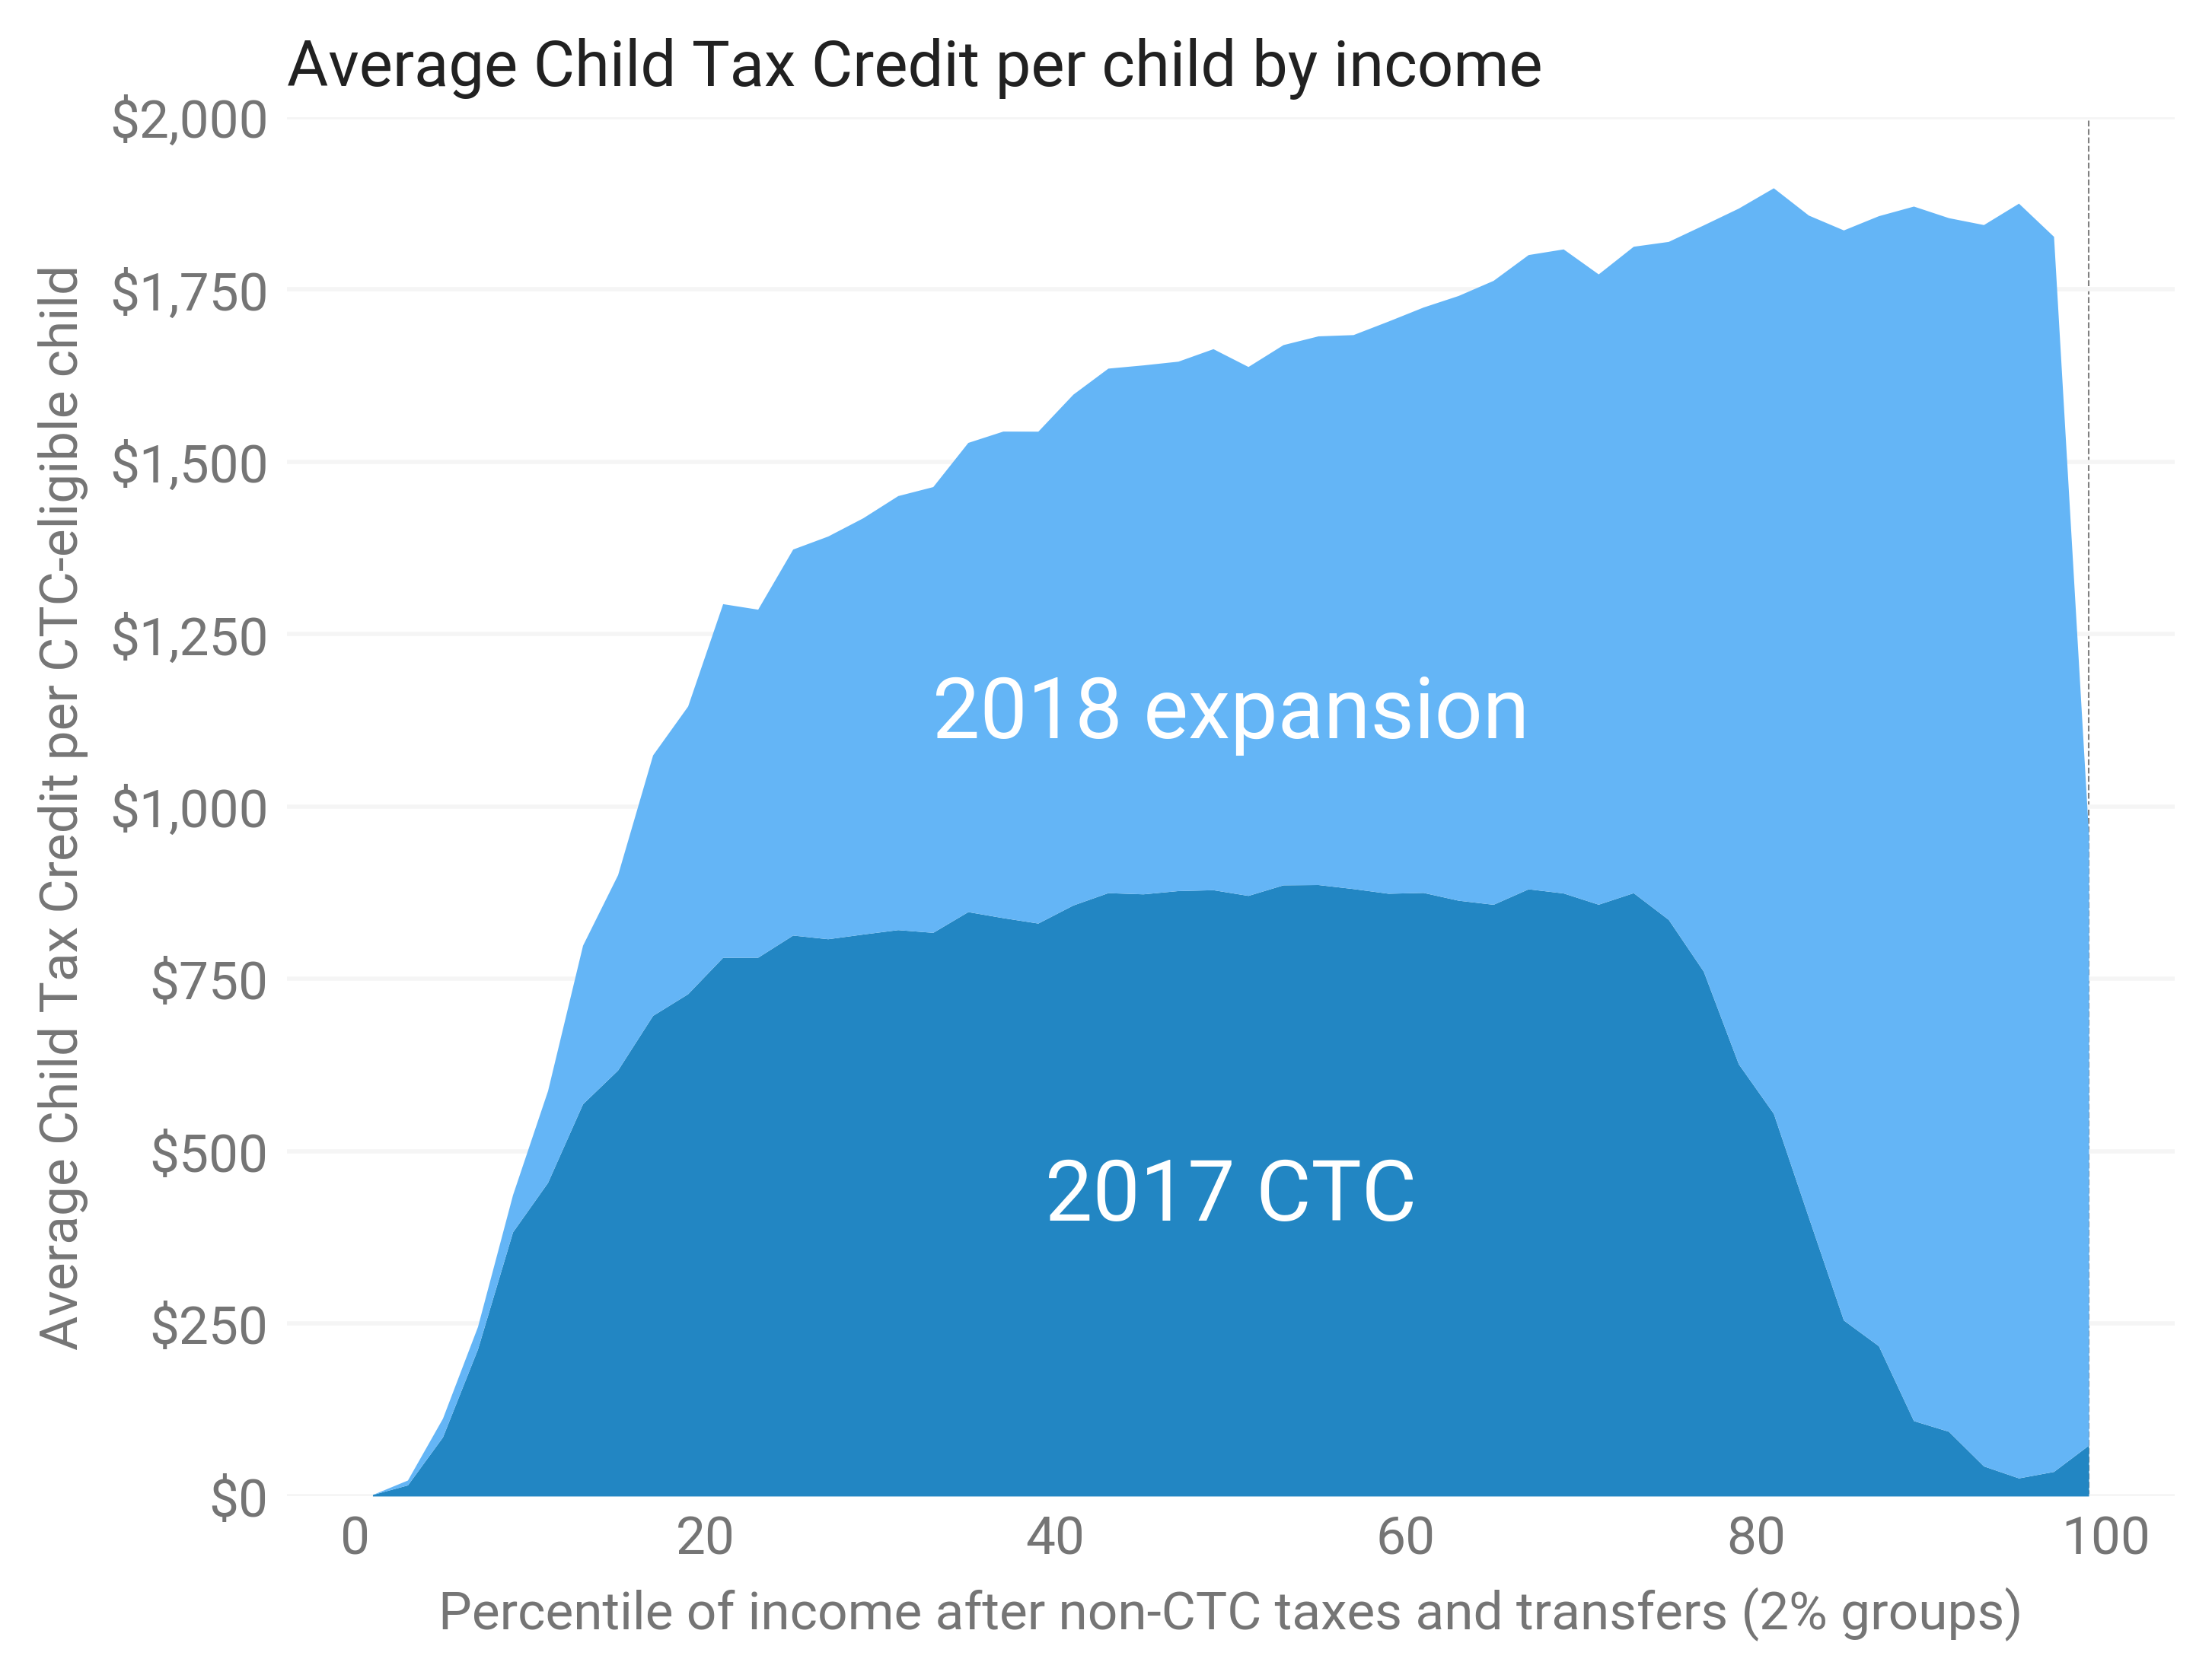

In [33]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
ax = twopct.plot(x='percentile', y=['ctc_per_n24_2017', 'ctc_per_n24_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0)
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after non-CTC taxes and transfers (2% groups)',
       ylabel='Average Child Tax Credit per CTC-eligible child',
       ylim=(0, 2000))
plt.axvline(x=99, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', 
        size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', 
        color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.title('Average Child Tax Credit per child by income', loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

## UBI vs. CTC

### Distributional impact

In [34]:
rn_ubi_str

'$1,500'

In [35]:
# One line.
UBI_LABEL = rn_ubi_str + ' (revenue-neutral)'
TUBI_LABEL = '$2,000 (current maximum)'
# Two lines.
UBI_LABEL2 = rn_ubi_str + '\n(revenue-neutral)'
TUBI_LABEL2 = '\$2,000\n(current maximum)'
# Three lines.
UBI_LABEL3 = '\\' + rn_ubi_str + '\n(revenue-\nneutral)',
TUBI_LABEL3 = '\$2,000\n(current\nmaximum)'

UBI_COLOR = '#757575'
TUBI_COLOR = '#388e3c'

UBI_LABELS = [UBI_LABEL, TUBI_LABEL]
UBI_COLORS = [UBI_COLOR, TUBI_COLOR]
UBI_COLS = ['ubi_afti_pctchg', 'tubi_afti_pctchg']

YLAB = 'Change to income after taxes and transfers'

#### Impact by quartile

In [36]:
quart[UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_quartile,,
1,7.16,11.50
2,-0.18,1.83
3,-0.60,0.67
4,-0.31,0.23


Overall impact on upper 75%.

In [37]:
upper_75p = quart.loc[2:].sum()
add_ratios(upper_75p)
with pd.option_context('precision', 2):
    print(upper_75p[UBI_COLS])

ubi_afti_pctchg    -0.36
tubi_afti_pctchg    0.58
dtype: float64


/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


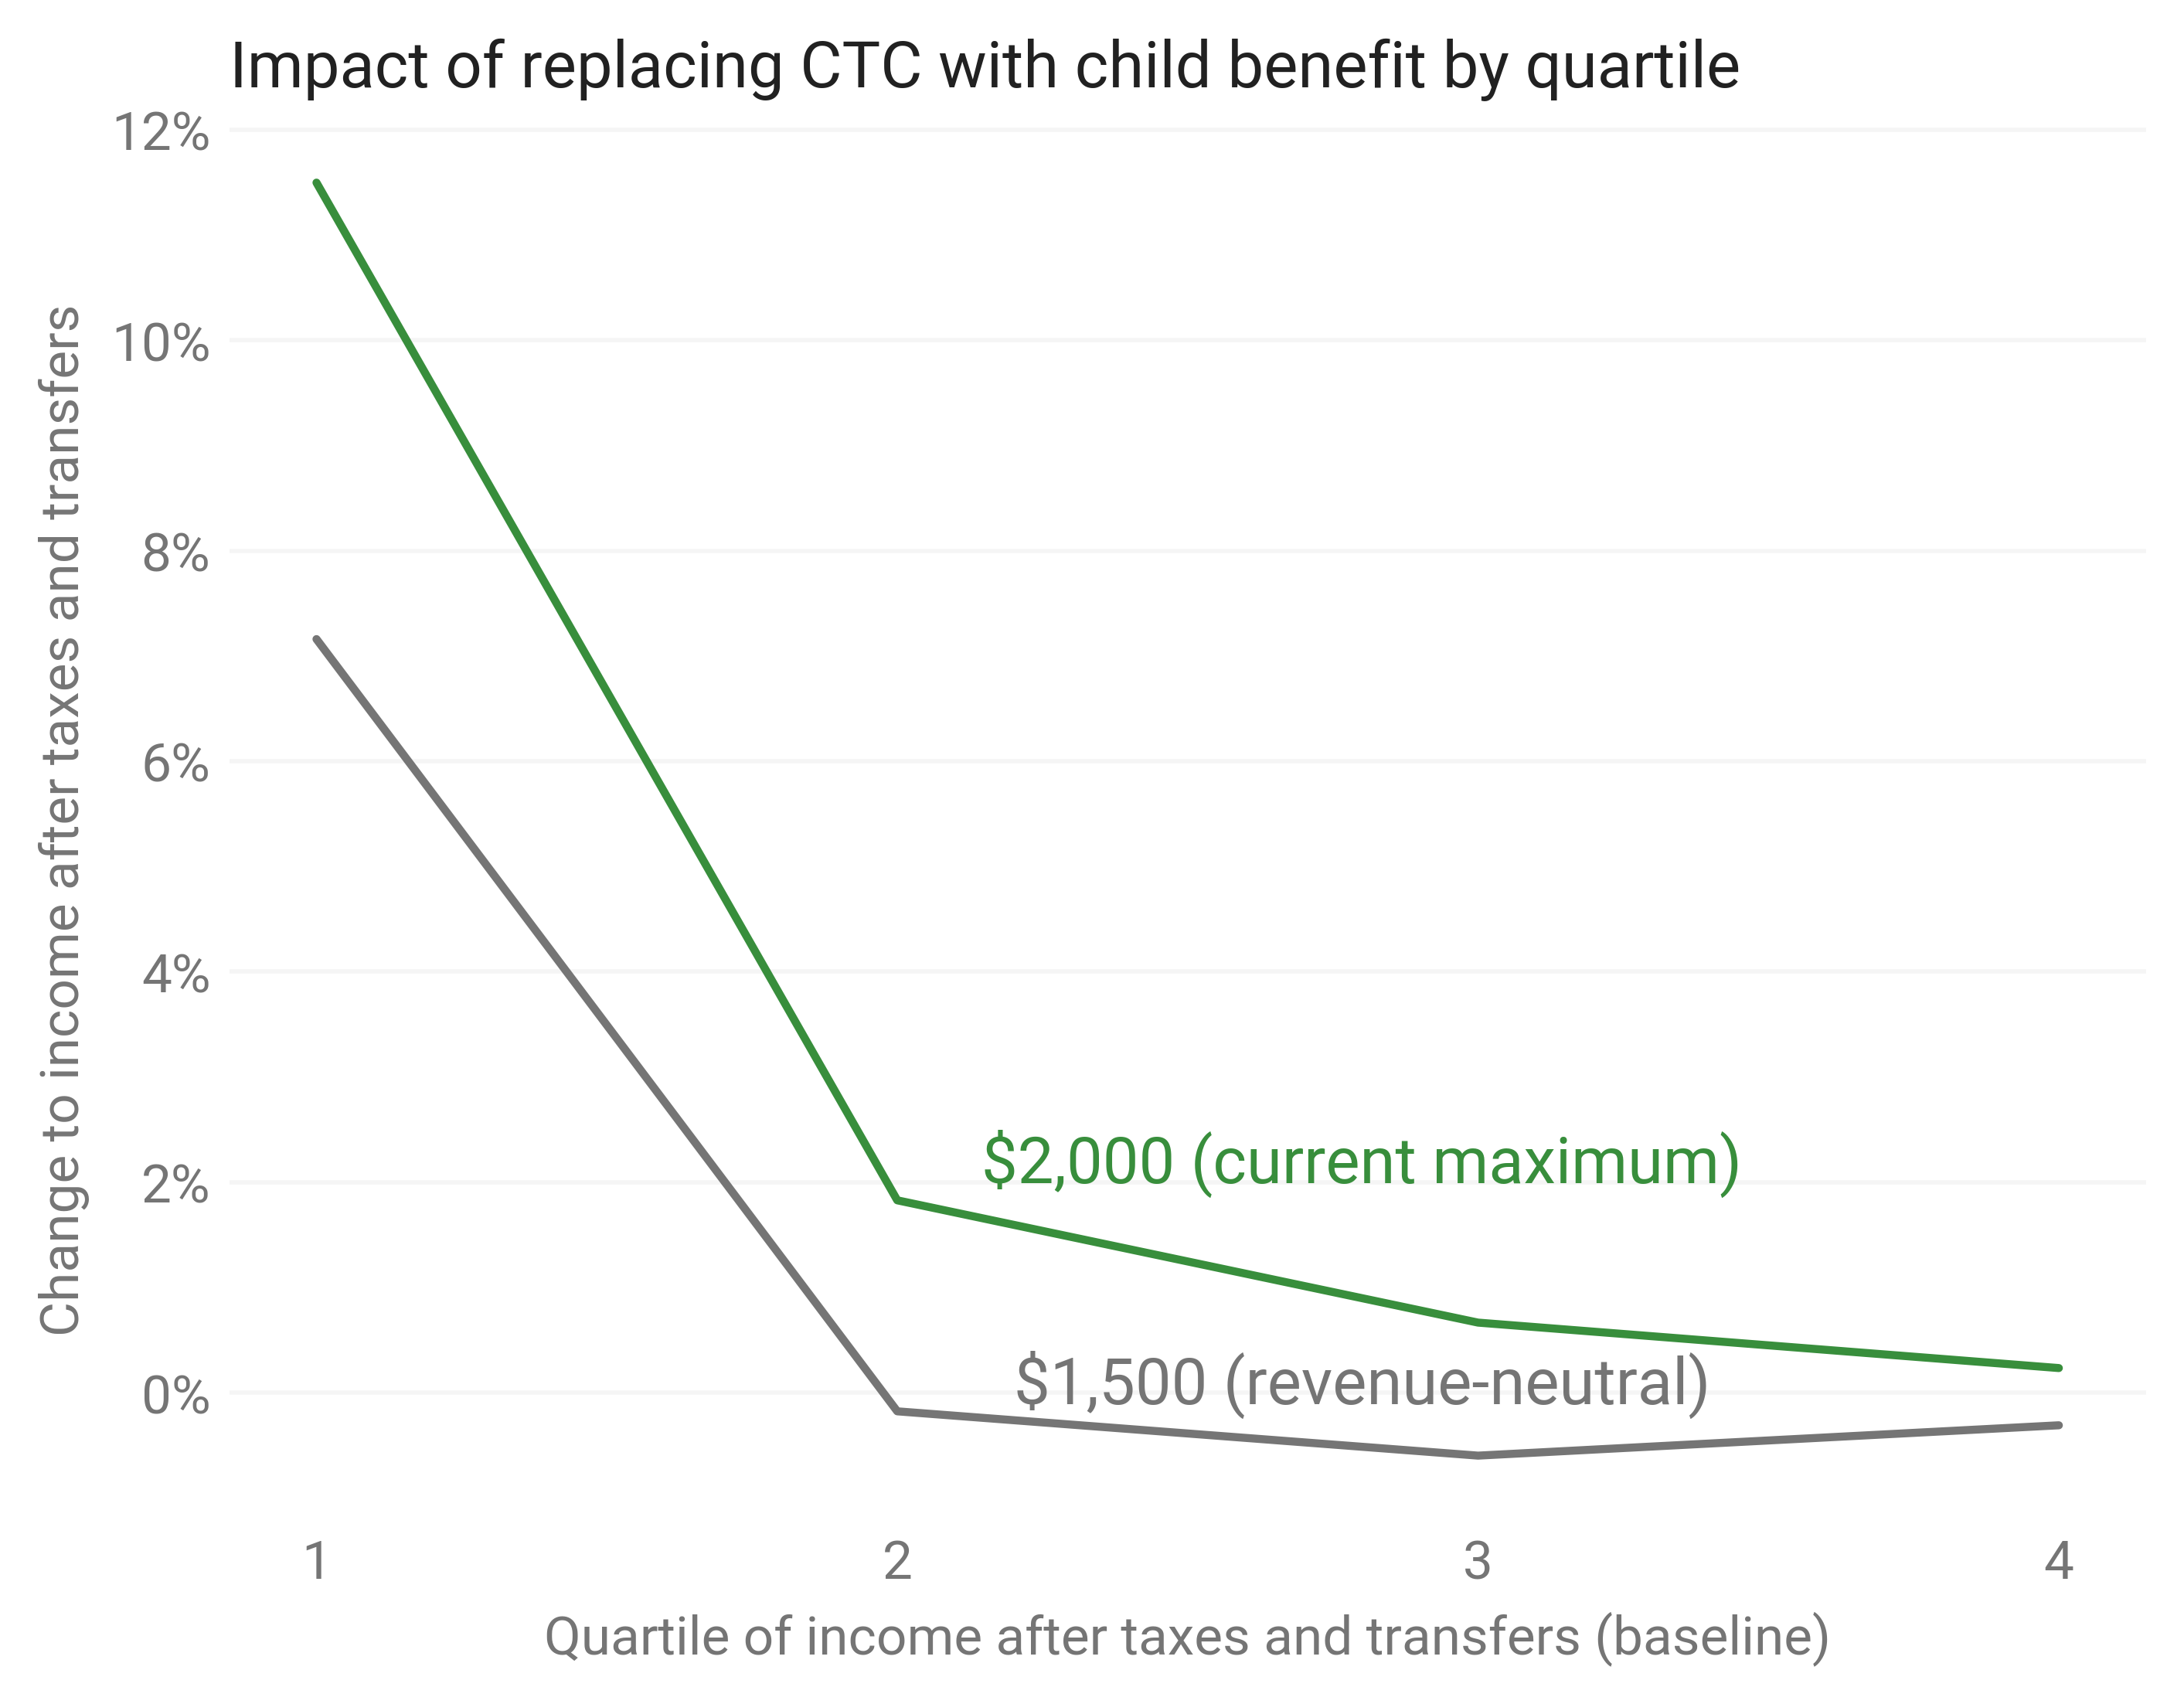

In [38]:
ax = quart.plot(y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(2.8, 2, TUBI_LABEL, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(2.8, -0.1, UBI_LABEL, horizontalalignment='center', 
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Quartile of income after taxes and transfers (baseline)',
       ylabel=YLAB,
       xticks=[1, 2, 3, 4])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Impact of replacing CTC with child benefit by quartile', 
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

#### Bottom quartile

In 5% increments.

In [39]:
vent.loc[:5, ['ubi_afti_pctchg', 'tubi_afti_pctchg', 'keep_afti_pp', 's006']]

,ubi_afti_pctchg,tubi_afti_pctchg,keep_afti_pp,s006
aftertax_income_ventile,,,,
1,120.81,161.76,1217.63,2.28e+06
2,17.43,24.71,6484.21,2.29e+06
3,5.91,9.72,9779.67,2.29e+06
4,2.39,5.24,11848.72,2.29e+06
5,1.03,3.58,12617.82,2.29e+06


\$1,218 per person per year is roughly $3.34 per day. 2.3M households in each ventile.

/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


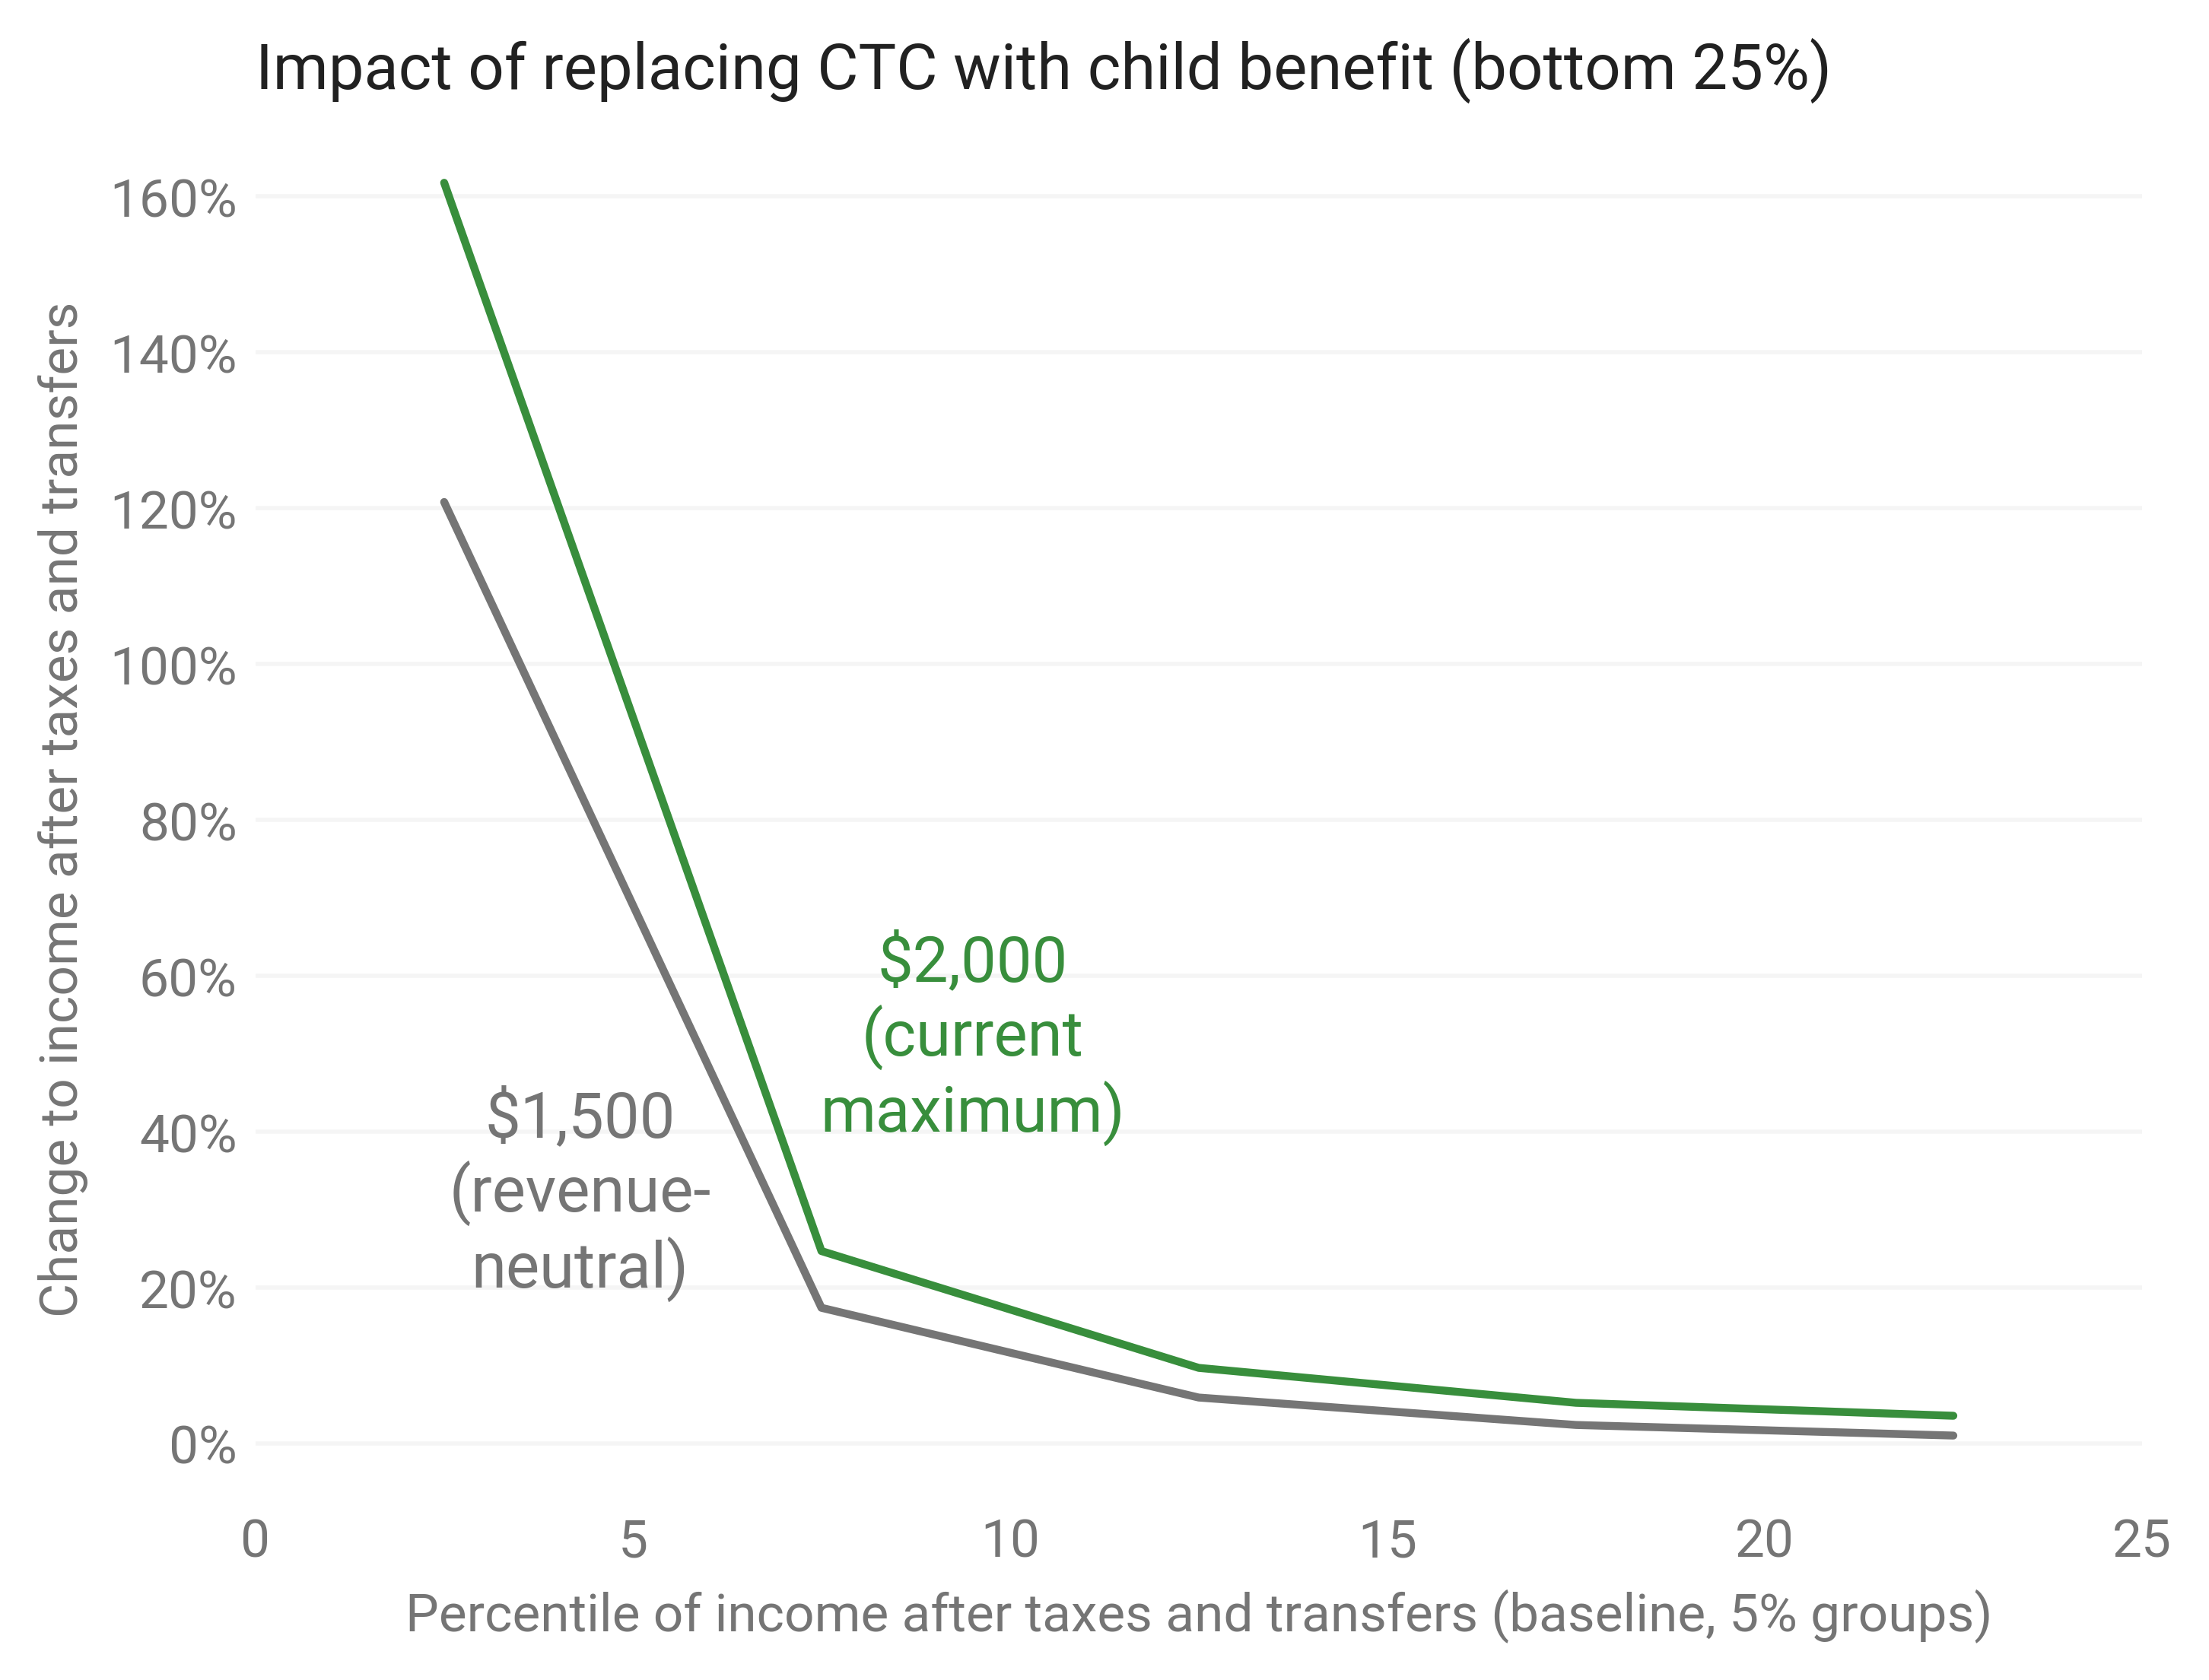

In [59]:
ax = vent[:5].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
# Using UBI_LABEL3 and TUBI_LABEL3 does not work.
ax.text(9.5, 40, '\$2,000\n(current\nmaximum)', horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(4.3, 20, rn_ubi_str + '\n(revenue-\nneutral)', 
        horizontalalignment='center',
        multialignment='center', color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 5% groups)',
       ylabel=YLAB,
       xlim=[0, 25])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (bottom 25%)', 
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

#### Impact on upper 75%.

In [41]:
twopct.loc[48:, UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_2percentile,,
48,-0.36,0.12
49,-0.26,0.14
50,0.21,0.41


/home/mghenis/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


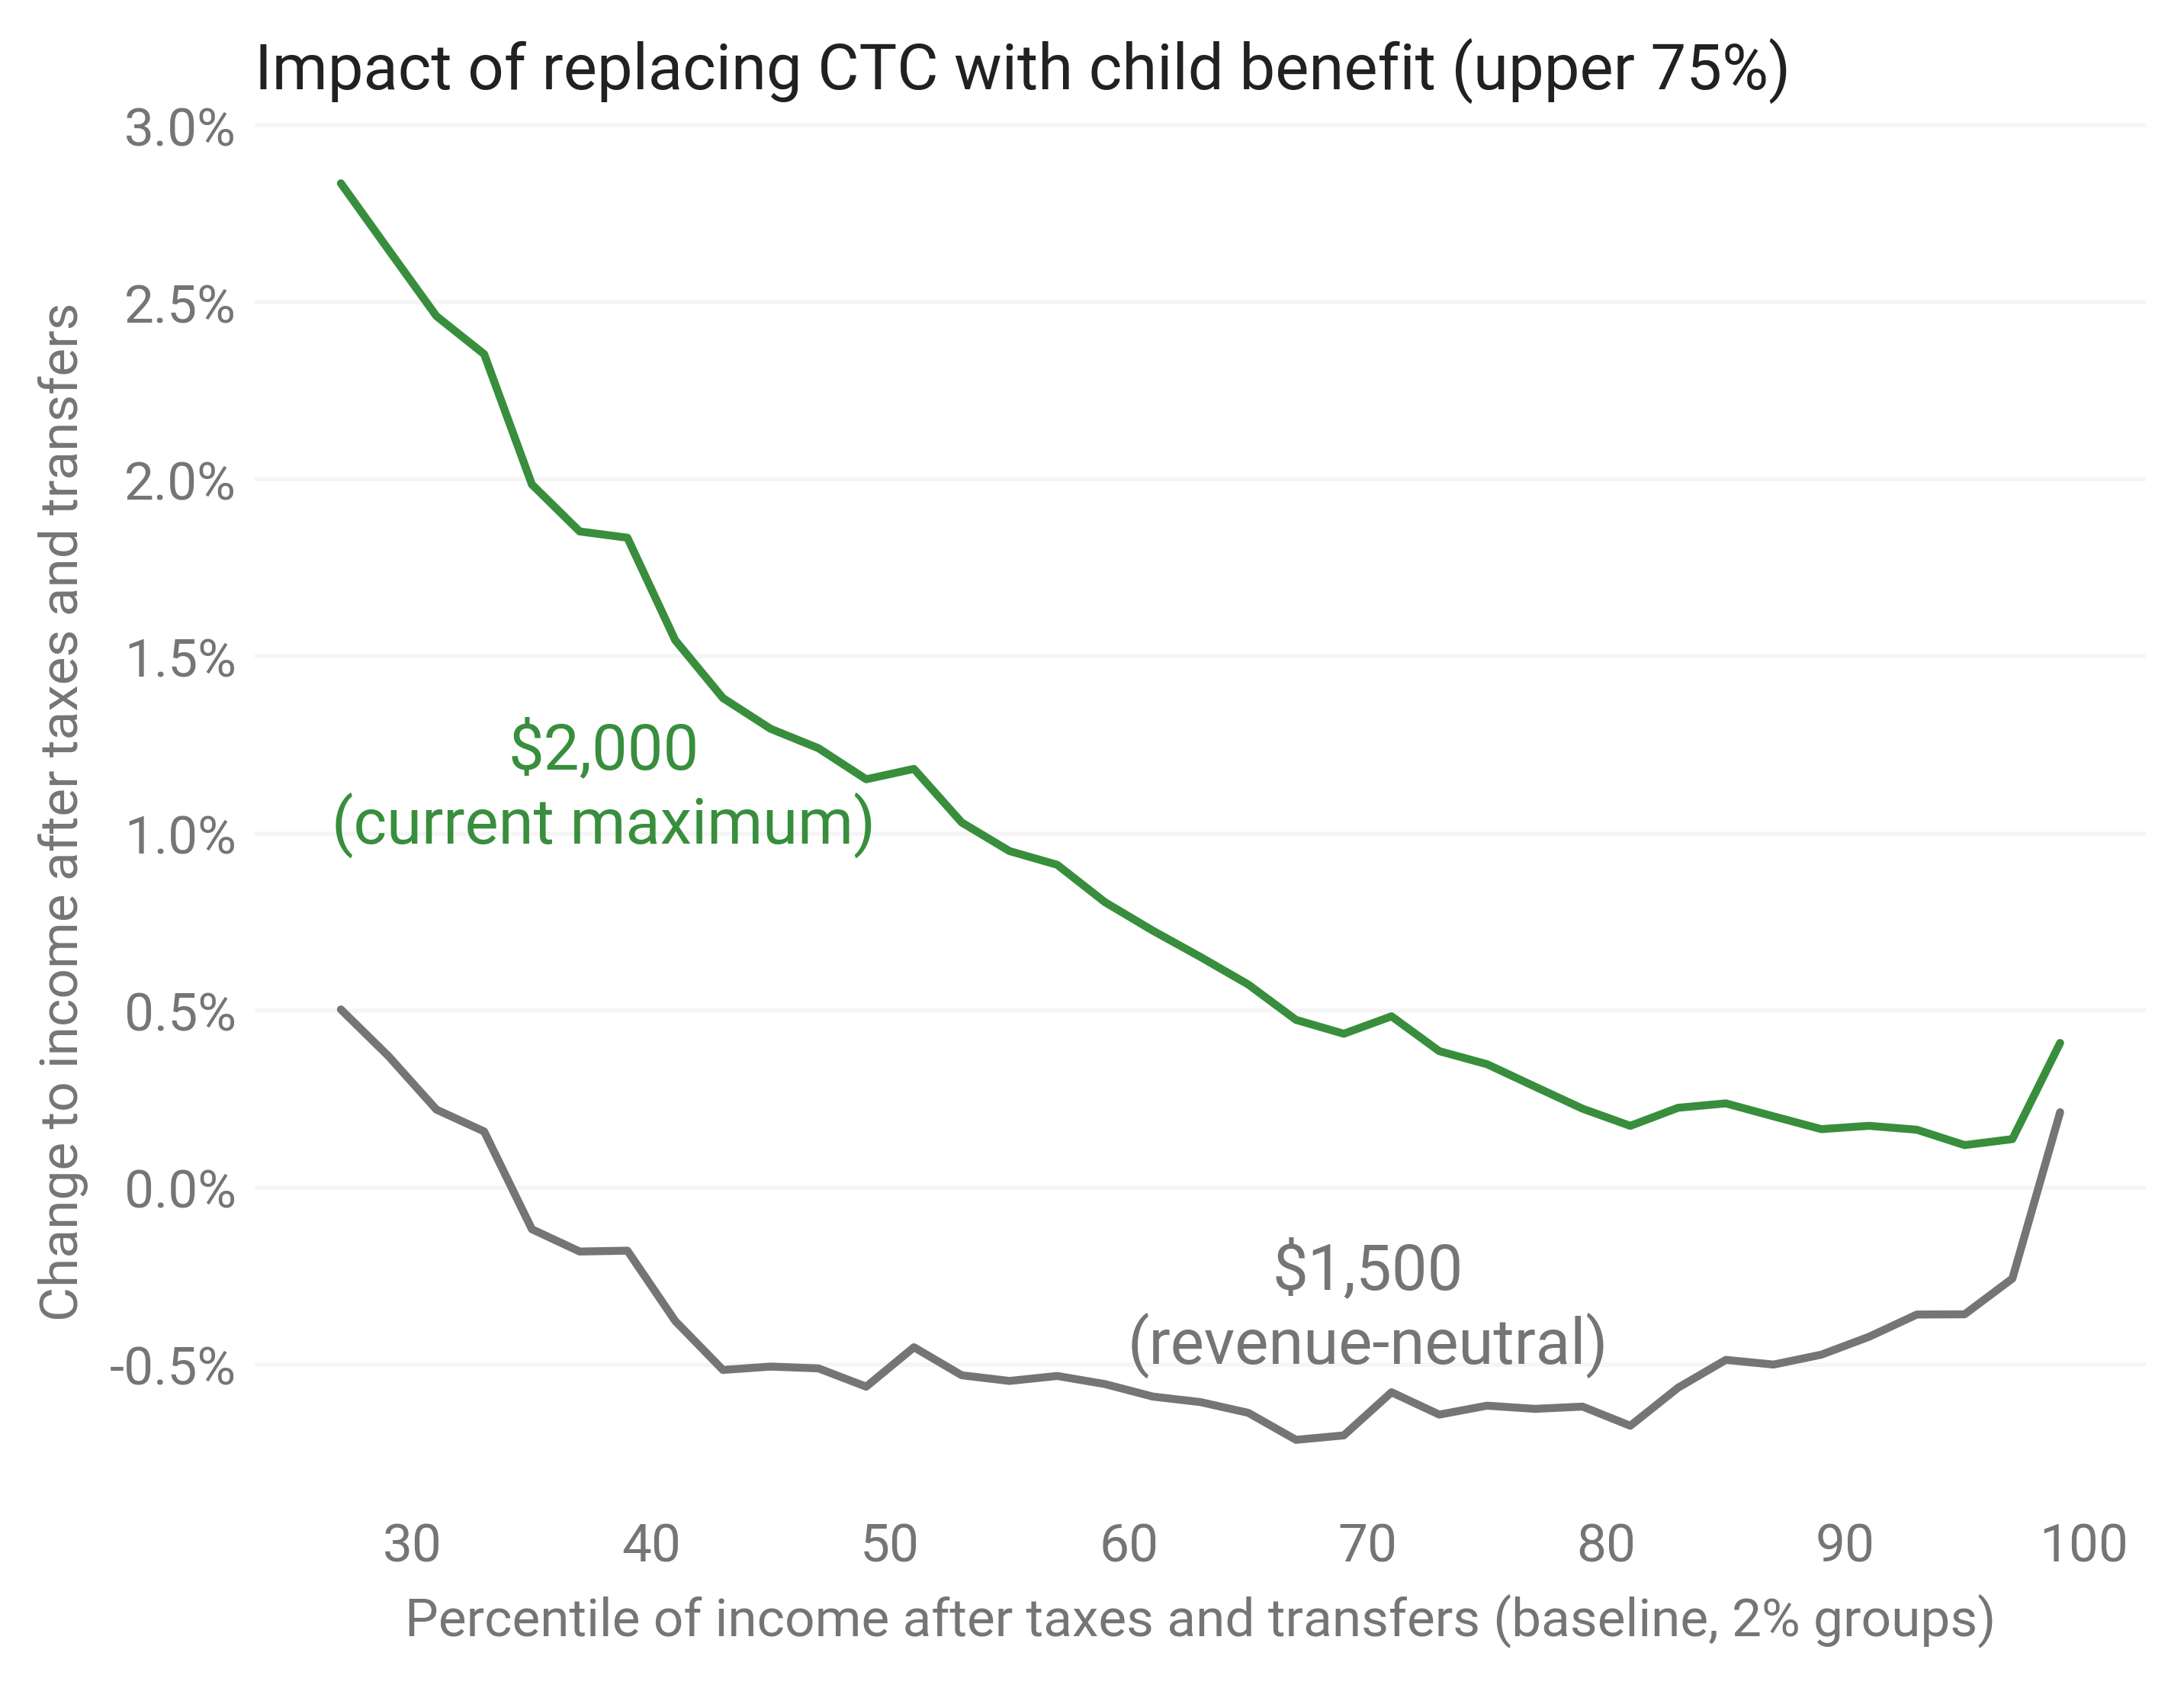

In [57]:
ax = twopct[13:].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
# ax.legend(UBI_LABELS)  # If new data.
ax.legend_.remove()
ax.text(38, 0.97, TUBI_LABEL2, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(70, -0.5, UBI_LABEL2, horizontalalignment='center',
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel=
       'Percentile of income after taxes and transfers (baseline, 2% groups)',
       ylabel=YLAB)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.1%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child benefit (upper 75%)',
          loc='left')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

Top 1% does better off. 2nd percentile is basically flat.

In [43]:
pct.loc[98:, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_percentile,,
98,-0.22,0.14
99,-0.08,0.22
100,0.35,0.50


In [44]:
twopct.loc[50, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

ubi_afti_pctchg     0.21
tubi_afti_pctchg    0.41
Name: 50, dtype: float64

### Inequality

#### Gini

In [45]:
ginis = pd.DataFrame({
    'keep': [gini(tu.afti_keep, tu.s006)],
    'repeal': [gini(tu.afti_repeal, tu.s006)],
    'ubi': [gini(tu.afti_ubi, tu.s006)],
    'tubi': [gini(tu.afti_tubi, tu.s006)]})

In [46]:
with pd.option_context('precision', 4):
    print(ginis)

     keep  repeal    tubi     ubi
0  0.4511  0.4602  0.4414  0.4459


### Poverty

In [47]:
tu['fpl'] = fpl(tu.XTOT)
tu['fpl_pp'] = tu.fpl / tu.XTOT
# Using $10k per person.
tu['pov_10k'] = 10000 * tu.XTOT
# $1.90 per day in 2011 dollars = $2.10 in 2018 dollars = $780/year.
EXTREME_POVERTY_LINE = 780
tu['extreme_pov'] = EXTREME_POVERTY_LINE * tu.XTOT

Average FPL per person (in tax units with children).

In [48]:
weighted_mean(tu, 'fpl_pp').round()

7646.0

Compare to average of 2.54 per 2017 Census data (https://www.statista.com/statistics/183648/average-size-of-households-in-the-us/).

In [49]:
AVG_HH_SIZE = 2.54
round(fpl(AVG_HH_SIZE) / AVG_HH_SIZE)

7399

In [50]:
def pov_rate(metric, afti, pov_line):
    return ((tu[metric] * (tu[afti] < tu[pov_line])).sum() / 
                      tu[metric].sum())

In [51]:
pov = pd.DataFrame([(metric, afti, pov_line) 
                    for metric in ['s006', 'n24_m']
                    for afti in ['afti_repeal', 'afti_keep', 
                                 'afti_ubi', 'afti_tubi']
                    for pov_line in ['fpl', 'pov_10k', 'extreme_pov']])
pov.columns = ['metric', 'afti', 'pov_line']
pov['pov_rate'] = pov.apply(lambda x: pov_rate(x.metric, x.afti, x.pov_line), 
                            axis=1)

In [52]:
# Widen for plotting.
pov_wide_n24 = pov[pov.metric == 'n24_m'].pivot_table(
    index='pov_line', columns='afti')
pov_wide_n24.columns = ['afti_keep', 'afti_repeal', 'afti_tubi', 'afti_ubi']
pov_wide_n24 = pov_wide_n24[['afti_repeal', 'afti_keep', 'afti_ubi', 
                             'afti_tubi']]

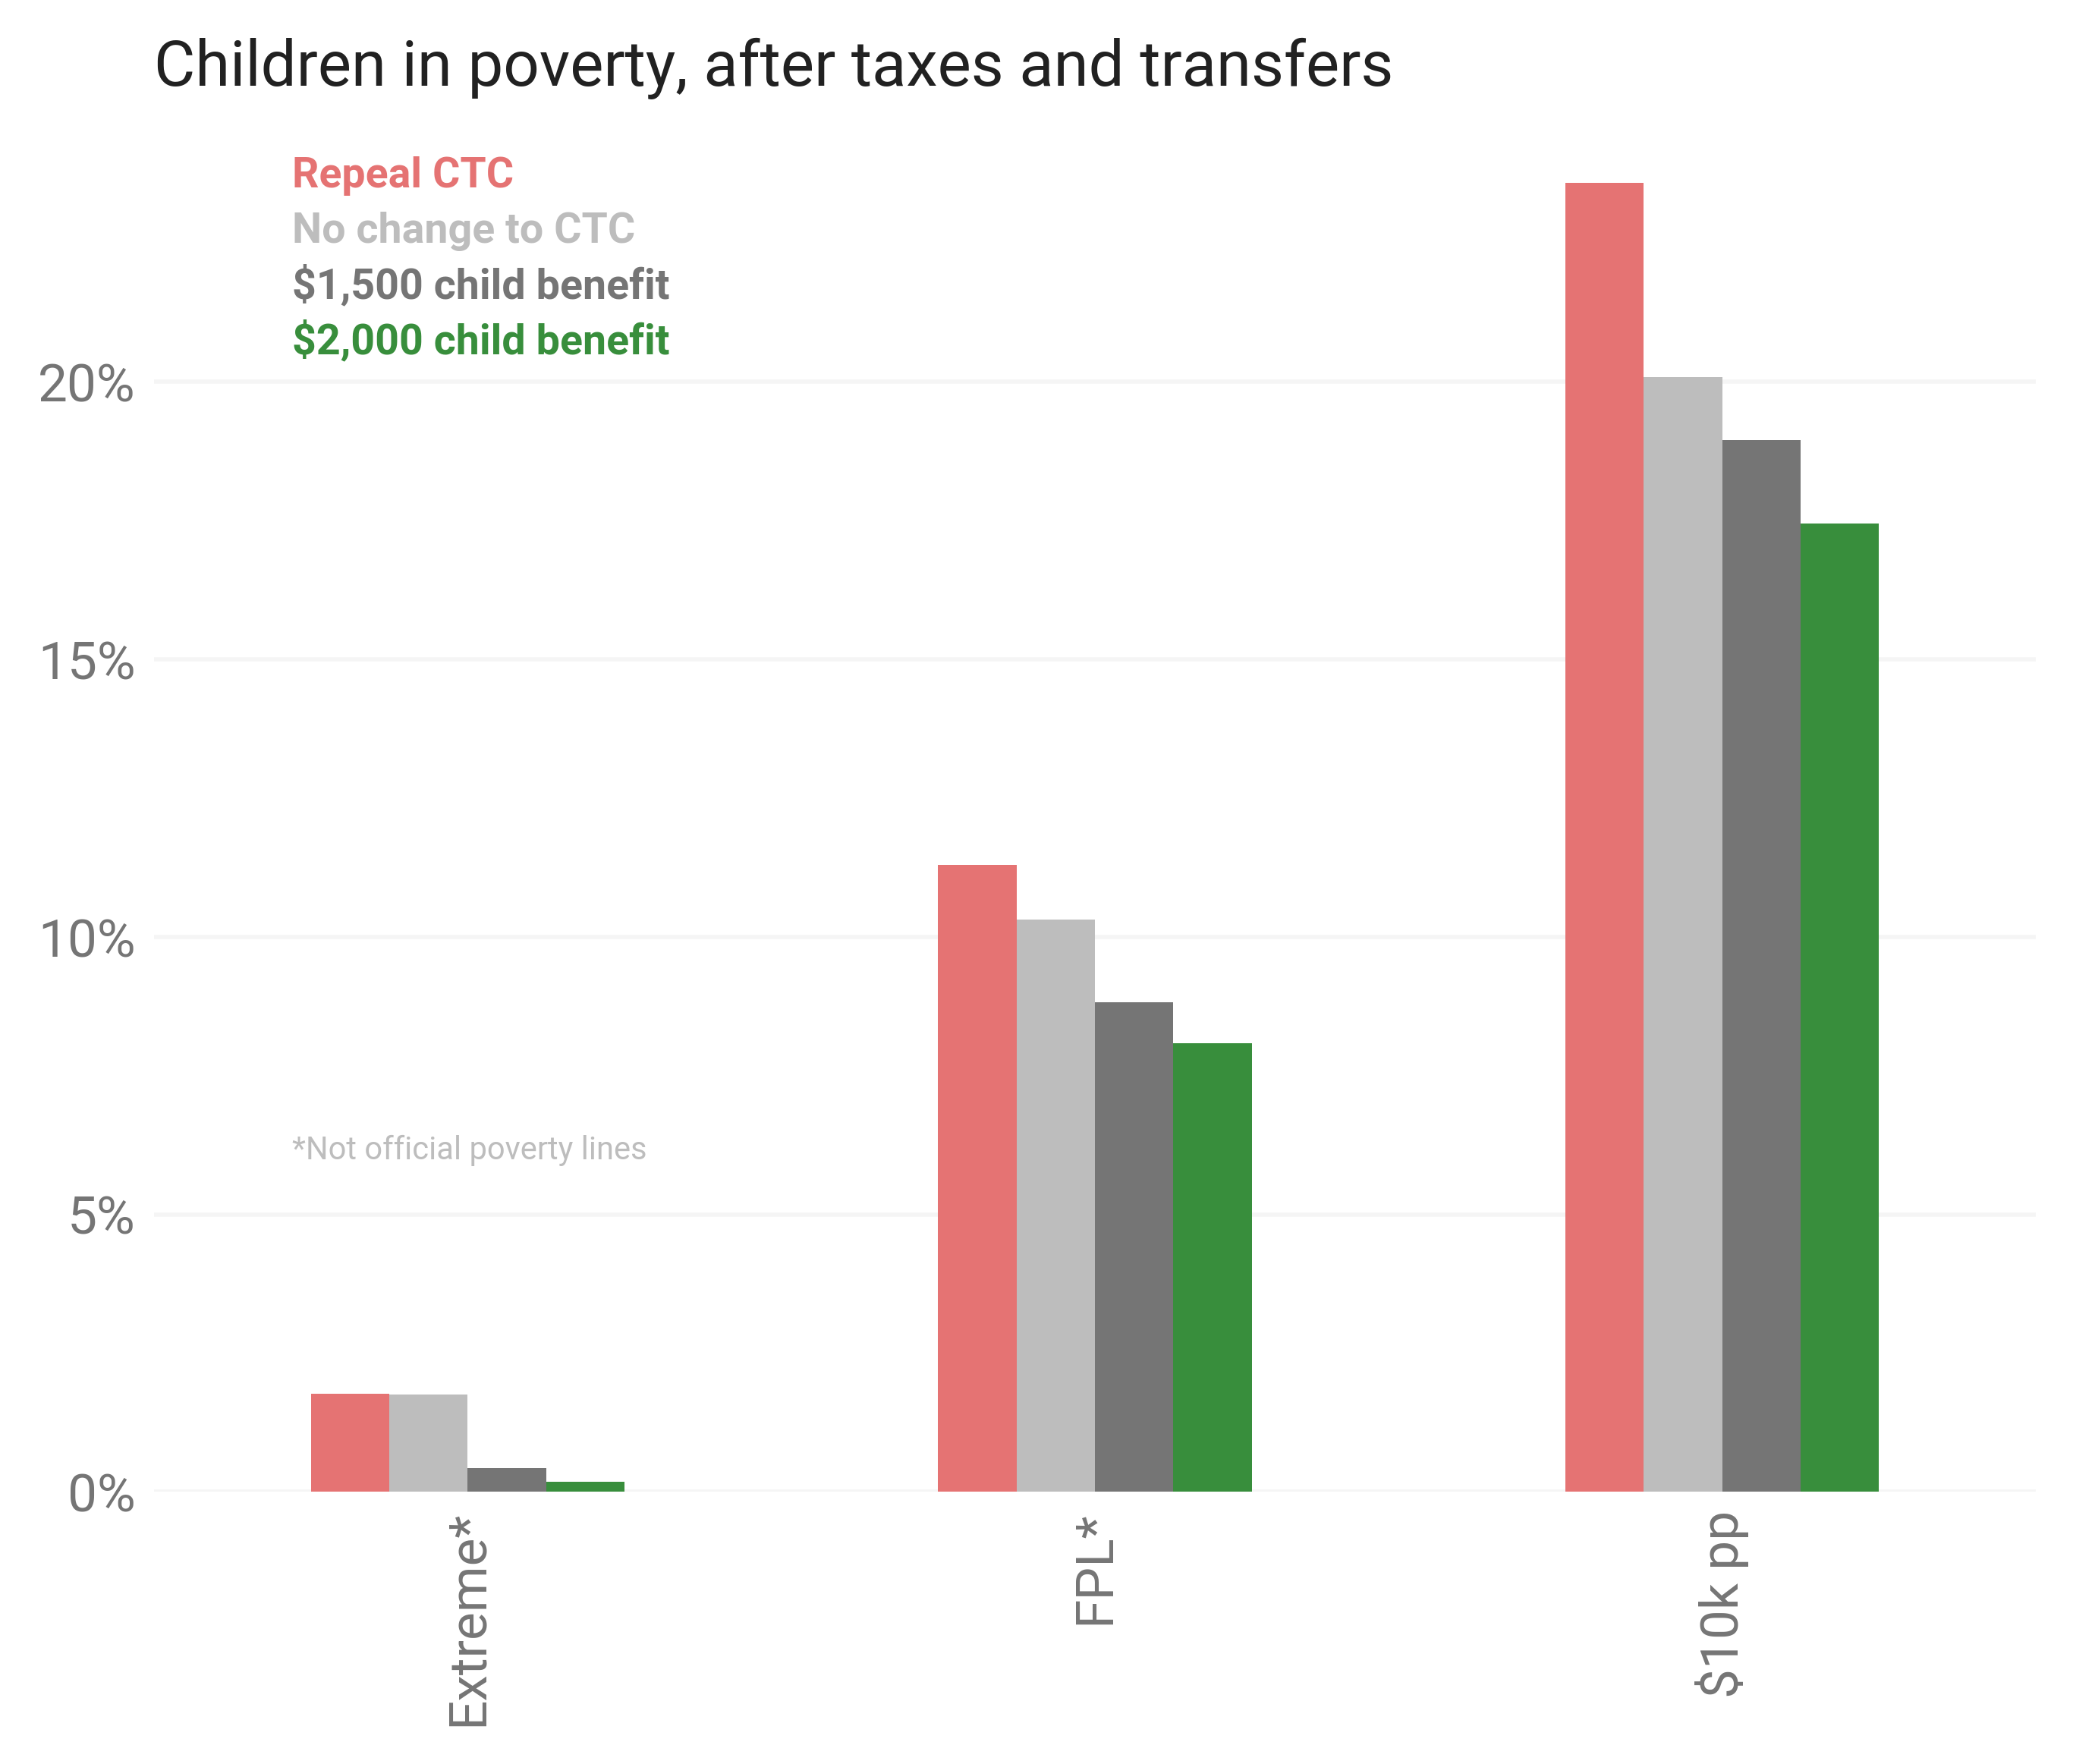

In [53]:
REPEAL_COLOR = '#e57373'  # Red from material.io/color.
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
ax = pov_wide_n24.plot.bar(
    color=[REPEAL_COLOR, KEEP_COLOR, UBI_COLOR, TUBI_COLOR])
ax.set_xticklabels(('Extreme*', 'FPL*', '$10k pp'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
ax.legend_.remove()
LEFT_X = -0.28
ax.text(LEFT_X, 0.235, 'Repeal CTC', horizontalalignment='left',
        color=REPEAL_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.225, 'No change to CTC', horizontalalignment='left',
        color=KEEP_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.215, rn_ubi_str + ' child benefit', 
        horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.205, '$2,000 child benefit', 
        horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children in poverty, after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
ax.grid(color='#f5f5f5', axis='y')
plt.show()

Relative reductions.

In [54]:
pov_wide_n24['ubi_reduction'] = 1 - (
    pov_wide_n24.afti_ubi / pov_wide_n24.afti_keep)
pov_wide_n24['tubi_reduction'] = 1 - (
    pov_wide_n24.afti_tubi / pov_wide_n24.afti_keep)
pov_wide_n24 * 100

,afti_repeal,afti_keep,afti_ubi,afti_tubi,ubi_reduction,tubi_reduction
pov_line,,,,,,
extreme_pov,1.76,1.75,0.43,0.19,75.55,89.42
fpl,11.30,10.31,8.82,8.08,14.52,21.64
pov_10k,23.58,20.07,18.95,17.44,5.59,13.12


## Appendix

### Tax units in poverty

In [55]:
# Widen and reorder for plotting.
pov_wide = pov.pivot_table(index=['pov_line', 'metric'], columns='afti')
pov_wide.columns = ['afti_keep', 'afti_repeal', 'afti_tubi', 'afti_ubi']
pov_wide = pov_wide[['afti_repeal', 'afti_keep', 'afti_ubi', 'afti_tubi']]

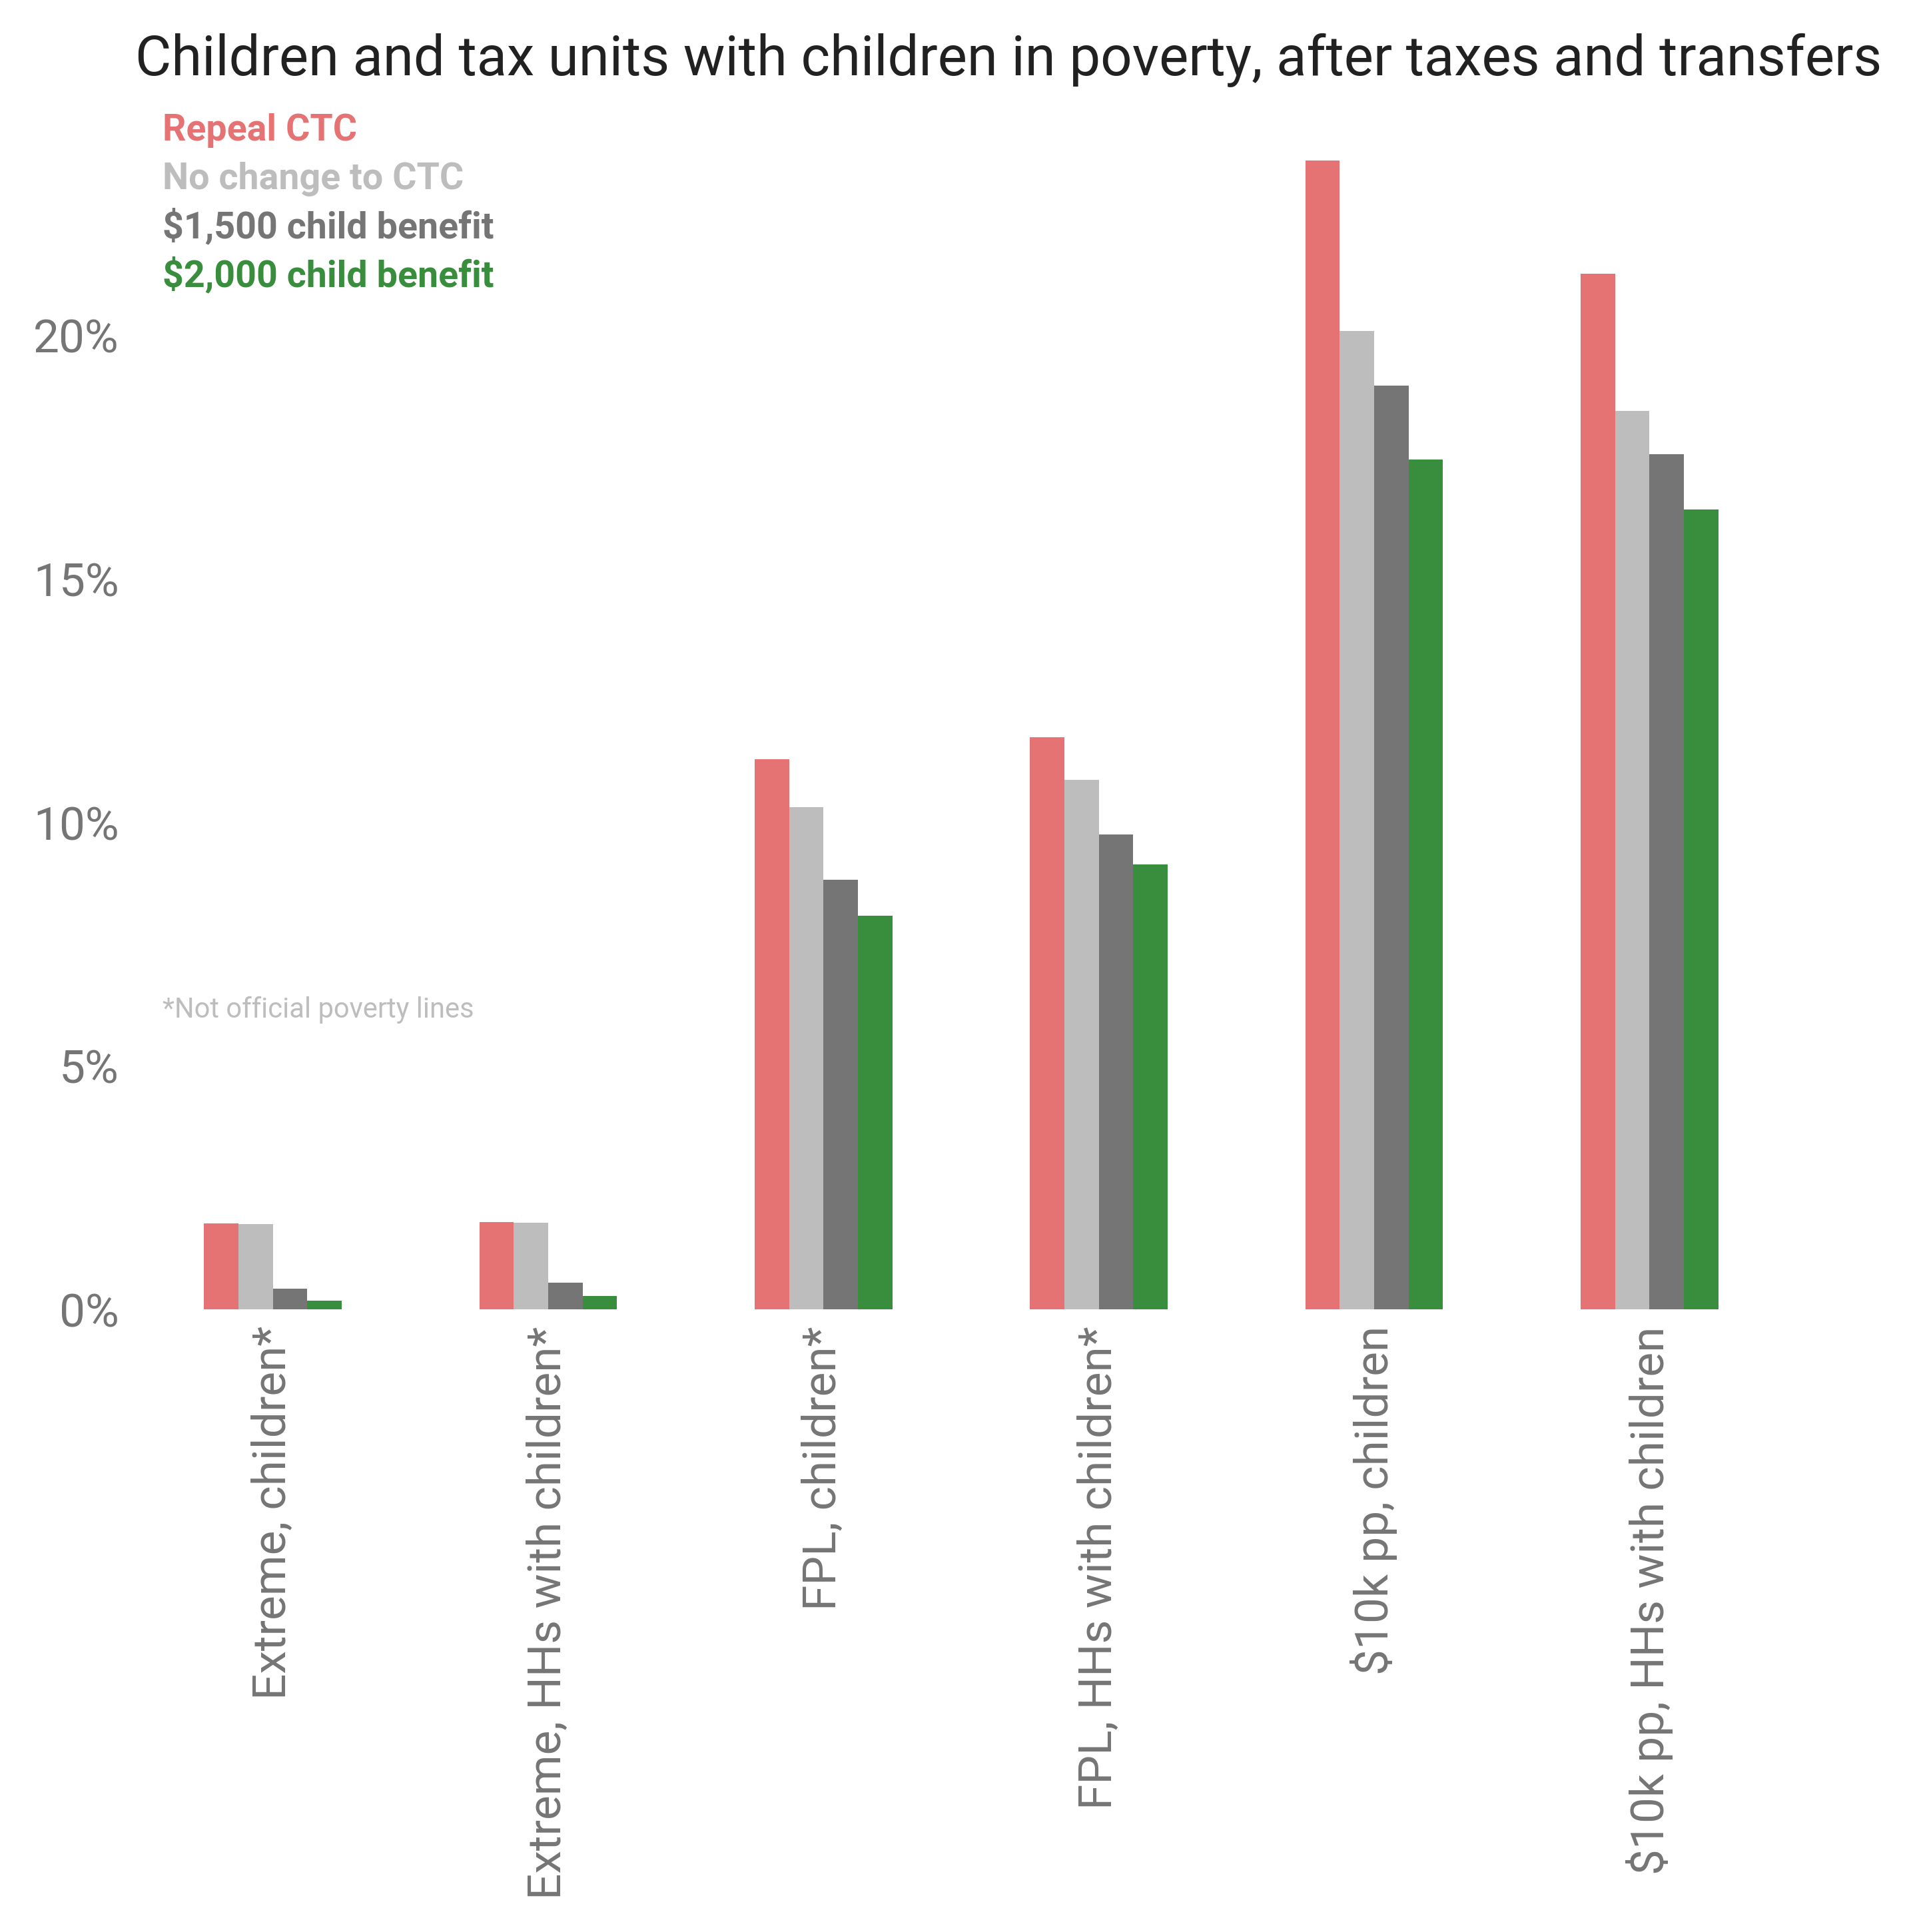

In [56]:
REPEAL_COLOR = '#e57373'  # Red from material.io/color.
KEEP_COLOR = '#bdbdbd'  # Light gray from material.io/color.
ax = pov_wide.plot.bar(color=[REPEAL_COLOR, KEEP_COLOR, UBI_COLOR, 
                              TUBI_COLOR])
ax.set_xticklabels(('Extreme, children*', 'Extreme, HHs with children*',
                    'FPL, children*', 'FPL, HHs with children*', 
                    '$10k pp, children', '$10k pp, HHs with children'))
sns.despine(left=True, bottom=True)
# Use text instead of legend.
ax.legend_.remove()
LEFT_X = -0.4
ax.text(LEFT_X, 0.24, 'Repeal CTC', horizontalalignment='left',
        color=REPEAL_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.23, 'No change to CTC', horizontalalignment='left',
        color=KEEP_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.22, rn_ubi_str + ' child benefit', 
        horizontalalignment='left', color=UBI_COLOR, size=8, weight='bold')
ax.text(LEFT_X, 0.21, '$2,000 child benefit', 
        horizontalalignment='left', color=TUBI_COLOR, size=8, weight='bold')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
plt.title('Children and tax units with children in poverty, ' +
          'after taxes and transfers', 
          loc='left')
ax.text(LEFT_X, 0.06, '*Not official poverty lines',
        horizontalalignment='left', color=KEEP_COLOR, size=6)
ax.set(xlabel='')
plt.show()